# Классификация и градиентные спуски

В этой тетрадке мы попробуем немного посмотреть на то, как работают разные градиентные спуски. 

# Простейшие нейронные сети на PyTorch


Фрэймворком для обучения нейросеток на нашем курсе будет PyTorch. PyTorch стал очень популярным благодаря интуитивно понятной парадигме программирования нейронных сетей, основанной на динамическом графе. Не так давно PyTorch создал свою экосистему https://pytorch.org/ecosystem/, которая содержит в себе библиотеки, решающие практически всевозможные задачи машинного обучения. 

Чтобы установить библиотеку PyTorch, отправляйтесь в консоль и пропишите 

```
Для Windows без GPU
pip install torch==1.6.0+cpu torchvision==0.7.0+cpu -f https://download.pytorch.org/whl/torch_stable.html

Для Windows c GPU
pip install torch==1.6.0+cu101 torchvision==0.7.0+cu101 -f https://download.pytorch.org/whl/torch_stable.html

Для Linux без GPU
pip install torch==1.6.0+cpu torchvision==0.7.0+cpu -f https://download.pytorch.org/whl/torch_stable.html

Для Linux c GPU
pip install torch==1.6.0+cu101 torchvision==0.7.0+cu101 -f https://download.pytorch.org/whl/torch_stable.html

Для Mac
pip install torch torchvision

pip install pytorch-lightning
```


In [ ]:
# Подгружаем pytorch 
import torch

print(torch.__version__)

1.12.1+cu113


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import warnings         # чтобы никто не мешал бесчинствам с кодом
warnings.filterwarnings("ignore") # обработка всевозсожных warnings путем их игнорирования

plt.style.use('ggplot')
%matplotlib inline

In [ ]:
# Detect if we are in Google Colaboratory
try:
    import google.colab
    IN_COLAB = True
except ImportError:
    IN_COLAB = False

from pathlib import Path
# Determine the locations of auxiliary libraries and datasets.
if IN_COLAB:
    google.colab.drive.mount("/content/drive")
    
    ROOT = Path("/content/drive/My Drive/HSE_DL_2022/week_02/")
    
    assert ROOT.is_dir(), "Have you forgotten to 'Add a shortcut to Drive'?"
    
    import sys
    sys.path.append(str(ROOT))
else:
    ROOT = Path(".")

Mounted at /content/drive


# 1. Выборка

Делать всё это мы будем на животных. Ежегодно около 7.6 миллионов бедных животных в США оказываются в приютах. Часть из них находит себе новую семью, часть возвращается к старому (бывает, что питомец потерялся и его нашли на улице), а часть погибает. Ужегодно усыпляется около 2.7 млн. собак и кошек.  

Используя датасет с входной информацией (цвет, пол, возраст и т.п.) из одного из приютов, мы попытаемся спрогнозировать что произойдёт с новыми животными, которые попадут в этот приют. Данные, используемые в тетрадке уже были предварительно обработаны и приведены в удобную для построения моделей форму. 

In [ ]:
X = pd.read_csv(f'{ROOT}/X_cat.csv', sep = '\t', index_col=0)
target = pd.read_csv(f'{ROOT}/y_cat.csv', sep = '\t', index_col=0,  names=['status'])

print(X.shape)
X.head()

(26729, 37)


,IsDog,Age,HasName,NameLength,NameFreq,MixColor,ColorFreqAsIs,ColorFreqBase,TabbyColor,MixBreed,...,SexStatus_Flawed,SexStatus_Intact,SexStatus_Unknown,Weekday_0,Weekday_1,Weekday_2,Weekday_3,Weekday_4,Weekday_5,Weekday_6
0,1,365.0,1,7,0.000157,1,0.032919,0.463624,0,1,...,1,0,0,0,0,1,0,0,0,0
1,0,365.0,1,5,0.000655,0,0.008092,0.015005,1,1,...,1,0,0,0,0,0,0,0,0,1
2,1,730.0,1,6,0.000052,1,0.026293,0.357521,0,1,...,1,0,0,0,0,0,0,0,1,0
3,0,21.0,0,7,0.285871,0,0.000471,0.058418,0,1,...,0,1,0,0,0,0,0,1,0,0
4,1,730.0,0,7,0.285871,0,0.023831,0.075353,0,0,...,1,0,0,0,0,0,0,1,0,0


В датасете находится около 27 тысяч наблюдений и 39 регрессоров. Посмотрим на то как выглядит распределение того, что произошло со зверятами по особям.

In [ ]:
target.status.value_counts()

Adoption           10769
Transfer            9422
Return_to_owner     4786
Euthanasia          1555
Died                 197
Name: status, dtype: int64

Видим, что классы несбалансированы. Попробуем оставит четыре класса и объединить класс умерших животных с классом животных, которых усыпили. 

In [ ]:
target = target.values
target[target == 'Died'] = 'Euthanasia'

Закодируем классы.

In [ ]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y = le.fit_transform(target)
y

array([2, 1, 0, ..., 0, 3, 3])

In [ ]:
len(y)

26729

In [ ]:
X.shape

(26729, 37)

Разобьём выборку на тренировочную и тестовую. 

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify = y, random_state = 42)

print(X_train.shape)
print(X_test.shape)

(21383, 37)
(5346, 37)


In [ ]:
from sklearn.preprocessing import StandardScaler
ss = StandardScaler()

X_train = ss.fit_transform(X_train)
X_test = ss.transform(X_test)

# 2. Архитектурка

In [ ]:
import torch
import torch.nn as nn            # содержит функции для реалзации архитектуры нейронных сетей
import torch.nn.functional as F  # содержит различные функции активации и не только
import torch.optim as optim
import torch.utils.data as data_utils

Функция для рисования графиков

In [ ]:
def plot(histories):
    plt.figure(figsize=(16,10))
    
    for name, val_loss in histories:
        plt.plot(val_loss, label=name)

    plt.legend()

 Соберем архитектуру модели

In [ ]:
INPUT_SIZE = 37
HIDDEN_SIZE = 25
OUTPUT_SIZE = 4
BATCH_SIZE = 1000
EPOCHS = 105
LEARNING_RATE = 0.001

def build_model():
    model = nn.Sequential(  
        # Добавляем в нашу модель первый слой из 25 нейронов
        nn.Linear(in_features=INPUT_SIZE, out_features=HIDDEN_SIZE),
        nn.Sigmoid(),
        
        # Добавляем ещё один слой из 25 нейронов
        nn.Linear(in_features=HIDDEN_SIZE, out_features=HIDDEN_SIZE),
        nn.Sigmoid(),
        
        # Выходной вектор на количество классов, получаем с помощью такого же линейного приеобразования,
        # как и предыдущие слои, но уже на нужное количество выходных нейронов (т.е. классов)
        nn.Linear(in_features=HIDDEN_SIZE, out_features=OUTPUT_SIZE),
        nn.Softmax()
    )

    return model

Напишем функцию, которая будет тренировать нейронную сеть. Функция имеет 2 логические части: первая - тренировочная, вторая - валидационная, другими словами, та, на которой вычисляется ошибка и сравнивается с ошибкой на тренировочных данных

In [ ]:
def run_train(model, optimizer, criterion, scheduler=None):
    train_loss_values = []
    train_accuracy_values = []
    valid_loss_values = []
    valid_accuracy = []
    lr_history = []

    model.train()
    for epoch in range(EPOCHS):
        running_loss = []
        running_acc = []
        for features, label in train_loader:
            # Reset gradients
            optimizer.zero_grad()
            
            # run model on the chosen batch
            output = model(features)

            # Calculate error and backpropagate
            loss = criterion(output, label)
            loss.backward()

            # manual accuracy calculation; no torch lightning
            acc = (output.argmax(dim=1)==label).sum() / len(label)

            # Update weights with gradients
            optimizer.step()

            running_loss.append(loss.item())
            running_acc.append(acc)

        train_loss_values.append(np.mean(running_loss))
        train_accuracy_values.append(np.mean(running_acc))
        if epoch % 20 == 0:
            print('EPOCH %d,  train_loss: %f, train_accuracy: %f' % (epoch, train_loss_values[-1], train_accuracy_values[-1]))


        model.eval()
        # Run validation
        running_loss = []
        running_acc = []
        with torch.no_grad(): # in validation loop we do not need gradients calculation; so switch it off
            for features, label in test_loader:
                output = model(features)
                
                # Calculate error ana accuracy
                loss = criterion(output, label)
                acc = (output.argmax(dim=1)==label).sum() / len(label)

                running_loss.append(loss.item())
                running_acc.append(acc)

            valid_loss_values.append(np.mean(running_loss))
            valid_accuracy.append(np.mean(running_acc))
            if epoch % 20 == 0:
                print('EPOCH %d, valid_loss: %f, valid_accuracy: %f' % (epoch, valid_loss_values[-1], valid_accuracy[-1]))

        if scheduler is not None:
            # Decay Learning Rate
            scheduler.step()
            lr_history.append(scheduler.get_last_lr())

    if scheduler is not None:
        return train_loss_values, train_accuracy_values, valid_loss_values, valid_accuracy, lr_history
        
    return train_loss_values, train_accuracy_values, valid_loss_values, valid_accuracy

Создадим PyTorch `Dataloader`. Объект DataLoader принимает на вход датасет и ряд параметров, задающих процедуру формирования батча данных.

Основным входным параметром `Dataloader` является объект PyTorch `Dataset`. Он нужен для доступа к элементы данных по конкретному индексу. 

На первый взгляд такая конструкция может показаться странной и излишней. Однако к ней просто нужно привыкнуть и со временем станет понятно насколько она удобна и лаконична. В силу своей гибкости она позволяет формировать размер и структуру батча по желанию, а также собирать батч из заранее выбранных элементов данных. Такая кастомная сборка батча может пригодиться, например, при работе с последовательными данными, такими как предложения в тексте, имеющими разную длину. 

In [ ]:
def create_data_loader(X_train, y_train, X_test, y_test):
    train_tensor = data_utils.TensorDataset(torch.tensor(X_train.astype(np.float32)), torch.tensor(y_train))
    train_loader = data_utils.DataLoader(dataset=train_tensor,
                                         batch_size=BATCH_SIZE,
                                         shuffle=True)

    test_tensor = data_utils.TensorDataset(torch.tensor(X_test.astype(np.float32)), torch.tensor(y_test))
    test_loader = data_utils.DataLoader(dataset=test_tensor,
                                        batch_size=BATCH_SIZE,
                                        shuffle=False)
    return train_loader, test_loader

train_loader, test_loader = create_data_loader(X_train, y_train, X_test, y_test)

# 3. Оптимизация 

### SGD 

In [ ]:
model1 = build_model()
list(model1.parameters())[0].shape

torch.Size([25, 37])

In [ ]:
# Первая простенькая моделька 
model1 = build_model()

# инициализируем SGD optimizer
sgd = optim.SGD(model1.parameters(), lr=LEARNING_RATE)

# инициализируем Loss function (функцию потерь)
criterion = nn.CrossEntropyLoss()

# запускаем процесс обучения
train_loss_values, train_accuracy_values, valid_loss_values, valid_accuracy = run_train(model1, optimizer=sgd, criterion=criterion)

EPOCH 0,  train_loss: 1.391351, train_accuracy: 0.179684
EPOCH 0, valid_loss: 1.391021, valid_accuracy: 0.178717
EPOCH 20,  train_loss: 1.378635, train_accuracy: 0.179217
EPOCH 20, valid_loss: 1.378268, valid_accuracy: 0.179865
EPOCH 40,  train_loss: 1.367180, train_accuracy: 0.403673
EPOCH 40, valid_loss: 1.366827, valid_accuracy: 0.404994
EPOCH 60,  train_loss: 1.357256, train_accuracy: 0.402502
EPOCH 60, valid_loss: 1.356821, valid_accuracy: 0.404994
EPOCH 80,  train_loss: 1.348728, train_accuracy: 0.402209
EPOCH 80, valid_loss: 1.348220, valid_accuracy: 0.404994
EPOCH 100,  train_loss: 1.341401, train_accuracy: 0.402135
EPOCH 100, valid_loss: 1.340917, valid_accuracy: 0.404994


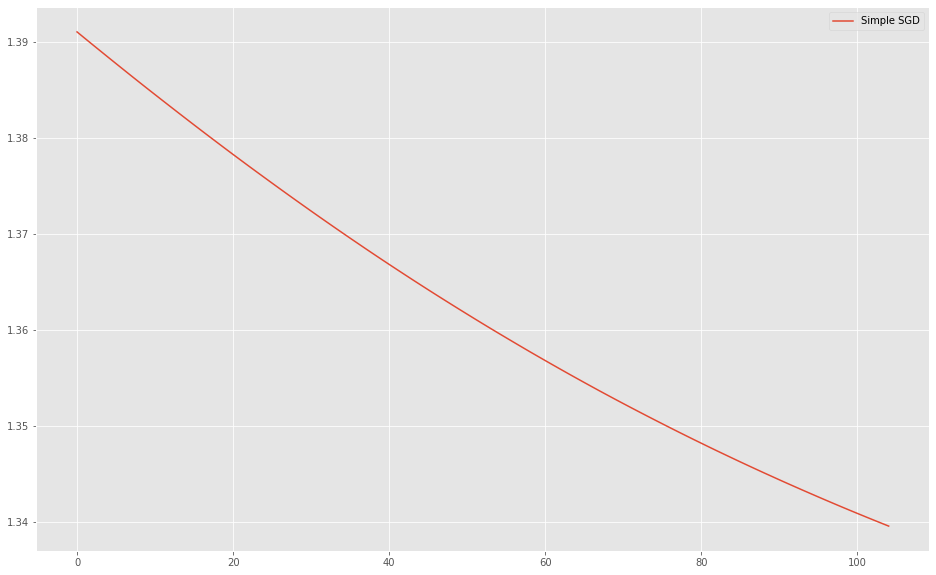

In [ ]:
plot([('Simple SGD', valid_loss_values)])

### Nesterov Momentum

In [ ]:
# Первая простенькая моделька 
model2 = build_model()

# инициализируем SGD optimizer
sgd = optim.SGD(model2.parameters(), lr=LEARNING_RATE, momentum=0.9, nesterov=True)

# запускаем процесс обучения
train_loss_values2, train_accuracy_values2, valid_loss_values2, valid_accuracy2 = run_train(model2, optimizer=sgd, criterion=criterion)

EPOCH 0,  train_loss: 1.368836, train_accuracy: 0.403820
EPOCH 0, valid_loss: 1.366264, valid_accuracy: 0.404994
EPOCH 20,  train_loss: 1.317945, train_accuracy: 0.402941
EPOCH 20, valid_loss: 1.316656, valid_accuracy: 0.404994
EPOCH 40,  train_loss: 1.304512, train_accuracy: 0.402794
EPOCH 40, valid_loss: 1.303750, valid_accuracy: 0.404994
EPOCH 60,  train_loss: 1.298182, train_accuracy: 0.403234
EPOCH 60, valid_loss: 1.297654, valid_accuracy: 0.404994
EPOCH 80,  train_loss: 1.294735, train_accuracy: 0.403527
EPOCH 80, valid_loss: 1.294427, valid_accuracy: 0.404994
EPOCH 100,  train_loss: 1.293267, train_accuracy: 0.401989
EPOCH 100, valid_loss: 1.292386, valid_accuracy: 0.404994


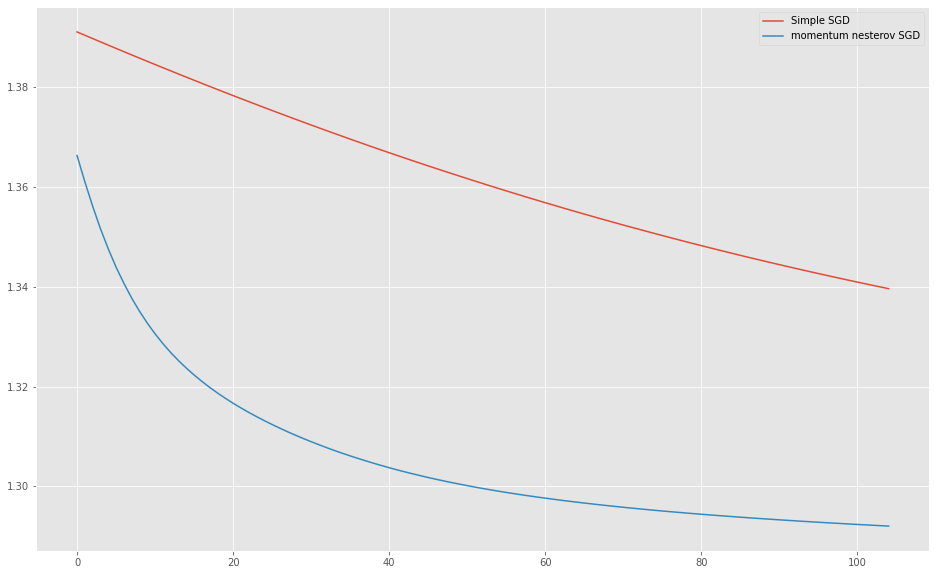

In [ ]:
plot([('Simple SGD', valid_loss_values), 
      ('momentum nesterov SGD', valid_loss_values2)])


### RMSprop 

In [ ]:
# Первая простенькая моделька 
model3 = build_model()

# инициализируем SGD optimizer
rmsprop = optim.RMSprop(model3.parameters(), lr=LEARNING_RATE, alpha=0.9, eps=1e-08)

# запускаем процесс обучения
train_loss_values3, train_accuracy_values3, valid_loss_values3, valid_accuracy3 = run_train(model3, optimizer=rmsprop, criterion=criterion)

EPOCH 0,  train_loss: 1.363134, train_accuracy: 0.322949
EPOCH 0, valid_loss: 1.339876, valid_accuracy: 0.350710
EPOCH 20,  train_loss: 1.128329, train_accuracy: 0.612753
EPOCH 20, valid_loss: 1.132737, valid_accuracy: 0.605896
EPOCH 40,  train_loss: 1.125912, train_accuracy: 0.614218
EPOCH 40, valid_loss: 1.131444, valid_accuracy: 0.606914
EPOCH 60,  train_loss: 1.118351, train_accuracy: 0.617390
EPOCH 60, valid_loss: 1.121385, valid_accuracy: 0.613193
EPOCH 80,  train_loss: 1.096210, train_accuracy: 0.642693
EPOCH 80, valid_loss: 1.102366, valid_accuracy: 0.636380
EPOCH 100,  train_loss: 1.087479, train_accuracy: 0.650029
EPOCH 100, valid_loss: 1.095227, valid_accuracy: 0.645825


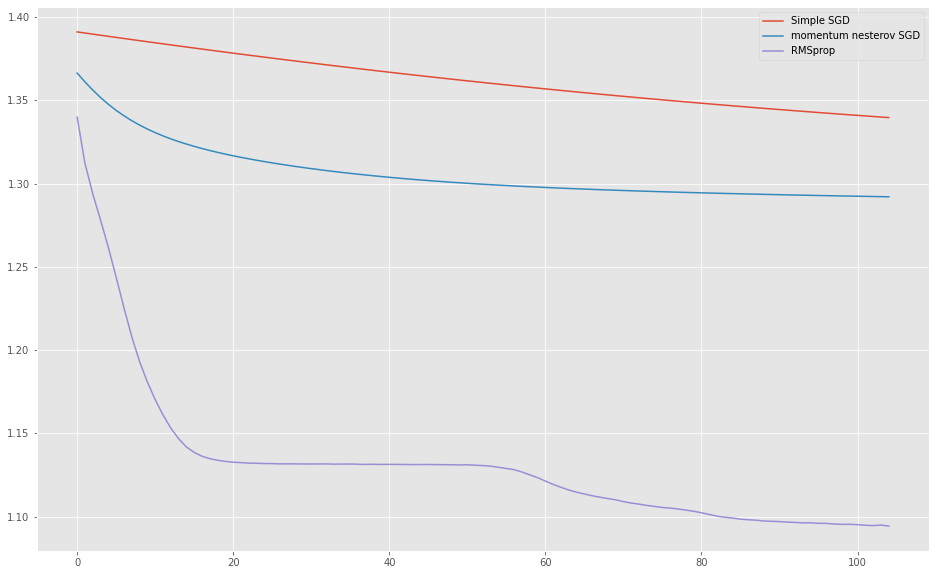

In [ ]:
plot([('Simple SGD', valid_loss_values), 
      ('momentum nesterov SGD', valid_loss_values2),
      ('RMSprop', valid_loss_values3)])


### Adam 

In [ ]:
# Первая простенькая моделька 
model4 = build_model()

# инициализируем SGD optimizer
adam = optim.Adam(model4.parameters(), lr=LEARNING_RATE, betas=(0.9, 0.999), eps=1e-08)

# запускаем процесс обучения
train_loss_values4, train_accuracy_values4, valid_loss_values4, valid_accuracy4 = run_train(model4, optimizer=adam, criterion=criterion)

EPOCH 0,  train_loss: 1.346788, train_accuracy: 0.401550
EPOCH 0, valid_loss: 1.327849, valid_accuracy: 0.404994
EPOCH 20,  train_loss: 1.130548, train_accuracy: 0.612506
EPOCH 20, valid_loss: 1.134766, valid_accuracy: 0.606063
EPOCH 40,  train_loss: 1.127005, train_accuracy: 0.613286
EPOCH 40, valid_loss: 1.132147, valid_accuracy: 0.606896
EPOCH 60,  train_loss: 1.125046, train_accuracy: 0.615031
EPOCH 60, valid_loss: 1.131421, valid_accuracy: 0.607081
EPOCH 80,  train_loss: 1.124757, train_accuracy: 0.614589
EPOCH 80, valid_loss: 1.130633, valid_accuracy: 0.606414
EPOCH 100,  train_loss: 1.123267, train_accuracy: 0.615468
EPOCH 100, valid_loss: 1.128984, valid_accuracy: 0.606451


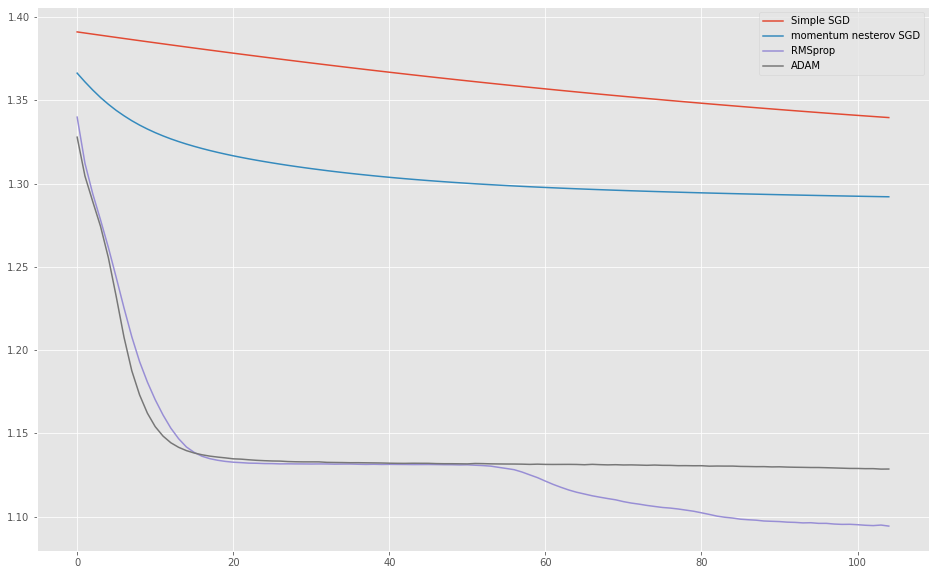

In [ ]:
plot([('Simple SGD', valid_loss_values), 
      ('momentum nesterov SGD', valid_loss_values2),
      ('RMSprop', valid_loss_values3),
      ('ADAM', valid_loss_values4)])


# 4. Стратегии с постепенным понижением lr 

![](https://raw.githubusercontent.com/FUlyankin/neural_nets_econ/master/2019/sem_2/ahaha.jpg)

In [ ]:
# функция для картинок, чтобы видеть как скорость обучения меняется от эпохи к эпохе
def plot_learning_rate(lr_history):
    fig = plt.figure()
    plt.plot(range(1, EPOCHS+1), lr_history, label='learning rate')
    plt.xlabel("epoch")
    plt.xlim([1, EPOCHS+1])
    plt.ylabel("learning rate")
    plt.legend(loc=0)
    plt.grid(True)
    plt.title("Learning rate")
    plt.show()

Стартовую скорость обучения специально берём большой! 

In [ ]:
INIT_LR = 0.1  # берём lr намеренно большим

In [ ]:
len(train_loader)

22

In [ ]:
from torch.optim.lr_scheduler import StepLR


# Первая простенькая моделька 
model5 = build_model()

# инициализируем SGD optimizer
adam = optim.Adam(model5.parameters(), lr=INIT_LR, betas=(0.9, 0.999), eps=1e-08)

# инициализируем 
scheduler = StepLR(adam, step_size=50, gamma=0.5)

# запускаем процесс обучения
train_loss_values5, train_accuracy_values5, valid_loss_values5, valid_accuracy5, lr_history5 = run_train(model5, optimizer=adam, 
                                                                                                        criterion=criterion, scheduler=scheduler)

EPOCH 0,  train_loss: 1.179636, train_accuracy: 0.559468
EPOCH 0, valid_loss: 1.140686, valid_accuracy: 0.602081
EPOCH 20,  train_loss: 1.104625, train_accuracy: 0.633359
EPOCH 20, valid_loss: 1.121901, valid_accuracy: 0.615268
EPOCH 40,  train_loss: 1.056651, train_accuracy: 0.683387
EPOCH 40, valid_loss: 1.092926, valid_accuracy: 0.645455
EPOCH 60,  train_loss: 1.030417, train_accuracy: 0.713031
EPOCH 60, valid_loss: 1.085082, valid_accuracy: 0.653900
EPOCH 80,  train_loss: 1.022403, train_accuracy: 0.721475
EPOCH 80, valid_loss: 1.088906, valid_accuracy: 0.650103
EPOCH 100,  train_loss: 1.016703, train_accuracy: 0.727152
EPOCH 100, valid_loss: 1.090002, valid_accuracy: 0.650030


In [ ]:
adam = optim.SGD(model5.parameters(), lr=INIT_LR)
scheduler = StepLR(adam, step_size=2, gamma=0.1)

for i in range(10):
    print(i+1, scheduler.get_last_lr())
    scheduler.step()

1 [0.1]
2 [0.1]
3 [0.010000000000000002]
4 [0.010000000000000002]
5 [0.0010000000000000002]
6 [0.0010000000000000002]
7 [0.00010000000000000003]
8 [0.00010000000000000003]
9 [1.0000000000000004e-05]
10 [1.0000000000000004e-05]


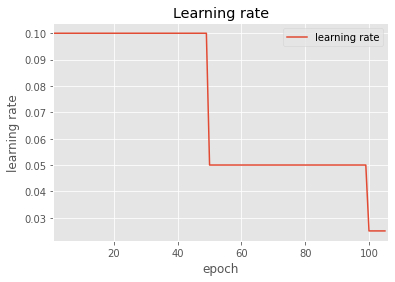

In [ ]:
# Смотрим как скорость обучения по немного понижалась
plot_learning_rate(lr_history5)

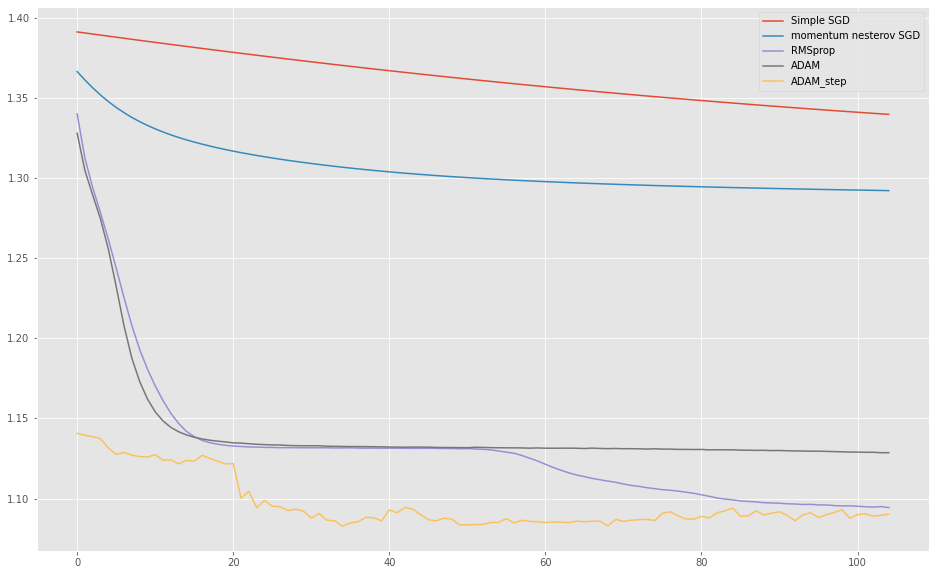

In [ ]:
plot([('Simple SGD', valid_loss_values), 
      ('momentum nesterov SGD', valid_loss_values2),
      ('RMSprop', valid_loss_values3),
      ('ADAM', valid_loss_values4),
      ('ADAM_step', valid_loss_values5)])

Попробуем ещё вариант!

In [ ]:
from torch.optim.lr_scheduler import MultiStepLR


# Первая простенькая моделька 
model6 = build_model()

# инициализируем SGD optimizer
adam = optim.Adam(model6.parameters(), lr=INIT_LR, betas=(0.9, 0.999), eps=1e-08)

# инициализируем 
scheduler = MultiStepLR(adam, milestones=[30,80], gamma=0.1)

# запускаем процесс обучения
train_loss_values6, train_accuracy_values6, valid_loss_values6, valid_accuracy6, lr_history6 = run_train(model6, optimizer=adam, 
                                                                                                        criterion=criterion, scheduler=scheduler)

EPOCH 0,  train_loss: 1.173427, train_accuracy: 0.560175
EPOCH 0, valid_loss: 1.136683, valid_accuracy: 0.605026
EPOCH 20,  train_loss: 1.107016, train_accuracy: 0.631938
EPOCH 20, valid_loss: 1.120533, valid_accuracy: 0.619565
EPOCH 40,  train_loss: 1.087795, train_accuracy: 0.654175
EPOCH 40, valid_loss: 1.119939, valid_accuracy: 0.617453
EPOCH 60,  train_loss: 1.083001, train_accuracy: 0.659925
EPOCH 60, valid_loss: 1.120876, valid_accuracy: 0.617768
EPOCH 80,  train_loss: 1.079421, train_accuracy: 0.664549
EPOCH 80, valid_loss: 1.121909, valid_accuracy: 0.616786
EPOCH 100,  train_loss: 1.079012, train_accuracy: 0.665084
EPOCH 100, valid_loss: 1.121851, valid_accuracy: 0.617601


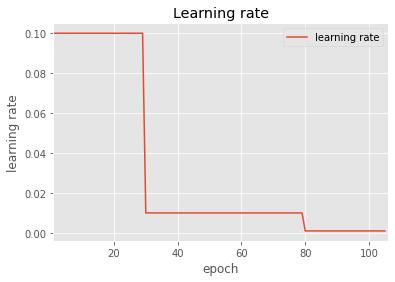

In [ ]:
# Смотрим как скорость обучения по немного понижалась
plot_learning_rate(lr_history6)

In [ ]:
plot([('Simple SGD', valid_loss_values), 
      ('momentum nesterov SGD', valid_loss_values2),
      ('RMSprop', valid_loss_values3),
      ('ADAM', valid_loss_values4),
      ('ADAM_step', valid_loss_values5),
      ('ADAM_step 2', valid_loss_values6)])

Существует множество различных Scheduler`ов. Полный список можно найти на [странице](https://pytorch.org/docs/stable/optim.html) в разделе "How to adjust learning rate"

Великолепное описание различных Scheduler`ов и как их применять можно найти по [ссылке](https://www.deeplearningwizard.com/deep_learning/boosting_models_pytorch/lr_scheduling/)

## Авторские права и почиташки 

* Для создания тетрадки использовался [вот этот мануал](https://github.com/sukilau/Ziff-deep-learning/blob/master/3-CIFAR10-lrate/CIFAR10-lrate.ipynb), адаптированный под PyTorch

##   Домашнее задание
Пришло время заняться исследованиями! На лекции мы с вами обсудили, что сегодня люди ставят довольно большое число разных экспериментов с циклической скоростью обучения. Делают они это, чтобы как-то соскальзывать с сёдел и выбираться из локальных минимумов.  В этом задании вам надо будет немного поэкспериментировать с такими скоростями обучения. Предлагается поизучать [Scheduler`ы](https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate), реализованные в PyTorch и выбрать 2-3 для сравнения с рассмотренными вариантами на семинаре

Вообще поощряются любые эксперименты. Не забывайте строить картинки. Можете как-то видоизменить архитектуру сетки. Например, добавить какие-то новые слои или сделать её глубже. Эксперименты можно оформлять прямо в этой тетрадке. Её же и присылайте.

Если хочется вдохновения, [в этой статье](https://www.jeremyjordan.me/nn-learning-rate/) можно найти много разных вариантов пересчёта скорости обучения. Есть варианты с циклами и даже косинусами! Единственное, что код в статье написан на Keras, но это никак не мешает изучить суть алгоритмов. Еще одна полезная [ссылка](https://www.deeplearningwizard.com/deep_learning/boosting_models_pytorch/lr_scheduling/), которую я уже приводил выше

Плодотворных экспериментов :) 

In [ ]:
# ваш код